# Simple Dataset Manipulation

This notebook represents a simple way to get data from the dataset.

Loading Libraries and Creating Function to load the dataset from the json file, as a Dictionary.

In [39]:
import numpy as np
import copy
import os
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation
np.set_printoptions(threshold=np.infty)
from utils_data_elab import VIC_OFF_X, VIC_OFF_Y, get_scenes, scene, obstacle, run, get_obs_info, get_scene_index


mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
# set axis label size to 25
mpl.rcParams['font.size'] = 25

path_to_json = "./data/"

def list_dataset(path):
    paths = []
    for p in os.listdir(path):
        if "maps" not in p and \
            ".csv" not in p and \
            "scene" not in p: paths.append(p)
    return paths

def dict_dataset(path):
    paths = {}
    for p in sorted(os.listdir(path)):
        if "maps" not in p and \
            ".csv" not in p and \
            "ignore" not in p and \
            "compress" not in p and \
            "scene" not in p and \
            os.path.isdir(os.path.join(path, p)): 
            # print(p.replace('run_', ''))
            x = str(int(p.replace('run_', '')))
            paths[x] = "run_"+x
    return paths

def load_dataset(path_to_json, datasets, dataset_index, verbose=False):
    if verbose: print(" Loading: ", datasets[dataset_index])
    data = open_json(path_to_json, datasets[dataset_index], verbose=verbose)
    # obstacles = open_json(path_to_json,"obstacles_scene"+str(data["scene_ID"])+".json")

    # # Translate the obstacles in the inertial reference frame
    # obstacles = np.array([np.subtract(obstacles['x'],3), np.subtract(obstacles['y'],2.7),obstacles['z']]).T

    # Load Poses
    poses = np.vstack(data["data_pose"])

    #Load mmWave Data (organised by timestamp)
    mmw_readings = [np.atleast_2d(v) for v in data["data_mmwave"]]
    # mmw_readings_np = np.vstack(mmw_readings)
    abs_mmw = apply_rototranslation(copy.deepcopy(mmw_readings), poses, offset_x=0, offset_y=0)

    # Sometimes poses contain useless information, so we remove them
    # poses = np.subtract(poses[:len(mmw_readings),:], [VIC_OFF_X, VIC_OFF_Y, 0.])
    return poses, abs_mmw, mmw_readings, data


def open_json(path_to_run, run, verbose=True):
    if verbose: print(" Loading Dataset: ", path_to_run, run)
    # json_path = path_to_run+run.replace('_', '')+"/dataset_"+run+".json"
    json_path = path_to_run+run+"/dataset_"+run+".json"
    json_path = os.path.join(os.getcwd(), json_path)
    with open(json_path) as json_file:
        data = json.load(json_file)

    if verbose:
        print("\n Available Data: ")
        for key in data.keys(): print("  - ", key)
    return data


def apply_rototranslation(mmw_readings, poses, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y):
    assert len(poses) >= len(mmw_readings), "Number of poses must be greater or equal than number of point clouds, but got {} and {}".format(len(poses), len(mmw_readings))
    
    
    # Compute Pointcloud Transformation
    # to_global = np.eye(4)
    abs_mmw = []
    for pc_o, pose in zip(np.copy(mmw_readings), np.copy(poses)):
        pc = pc_o[:, :3]

        # # pc = np.hstack( [ pc, np.ones( (pc_o.shape[0], 1) ) ]).T
        # # pose[:2] = np.subtract(pose[:2], [offset_x, offset_y])
        # # R = Rotation.from_euler('XYZ', [0,0, pose[2]]).as_matrix()
        # # to_global[:3, :3] = R
        # # to_global[:3, 3] = [pose[0], pose[1], 0.1]
        # # pc = np.matmul(to_global, pc).T

        pc = Rotation.from_euler('XYZ', [0,0, pose[2]]).apply(pc)
        pc = np.add(pc, [pose[0]-offset_x, pose[1]-offset_y, 0.1])
        
        pc_o[:, :3] = pc[:, :3]
        abs_mmw.append(pc_o)

    abs_mmw = np.vstack(abs_mmw)
    return abs_mmw

def plot_scene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        min_xlim=-3.5, 
        max_xlim=3.5, 
        min_ylim=-3.5, 
        max_ylim=3.5,
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([min_xlim, max_xlim])
    ax.set_ylim([min_ylim, max_ylim])
    ax.set_zlim([0, 1.5])
    ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c=colors)
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], fake_points[:, 2], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], obstacles[:, 2], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], 0.1, s=path_size+5, marker='o', c='green')
        ax.scatter(path[1:-1, 0], path[1:-1,1], np.full(len(path)-2, 0.1), s=path_size, marker='.', c='green')
        ax.scatter(path[-1, 0], path[-1, 1], 0.1, s=path_size+5, marker='x', c='green')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)

def plot_2dscene(point_cloud, 
        fake_points=[], 
        obstacles=[], 
        path=[], 
        colors=[], 
        pc_size=1,
        fake_pc_size=1,
        path_size=20, 
        min_xlim=-3.5, 
        max_xlim=3.5, 
        min_ylim=-3.5, 
        max_ylim=3.5,
        dest_path=None):
    # Plot Reconstructed Point Cloud
    fig = plt.figure(figsize=(13, 13))
    fig.set_tight_layout(True)
    ax = fig.add_subplot()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    # ax.set_zlabel('Z')
    ax.set_xlim([min_xlim, max_xlim])
    ax.set_ylim([min_ylim, max_ylim])
    # ax.set_zlim([0, 1.5])
    # ax.view_init(elev=90, azim=180)

    if np.shape(point_cloud)[1] > 3:
        colors = colors if len(colors) > 0 else point_cloud[:, 3]
    else: colors ='#689b64'
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], s=pc_size, marker='.', c='#689b64')
    # ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=pc_size, marker='.', c=colors)
    ax.scatter(point_cloud[:, 0], point_cloud[:, 1], s=pc_size, marker='.', c='#D3BD0F')
    
    if len(fake_points) > 0:
        ax.scatter(fake_points[:, 0], fake_points[:, 1], s=fake_pc_size, marker='.', c='#44546a')

    # Plot Obstacles
    if len(obstacles) > 0:
        ax.scatter(obstacles[:, 0], obstacles[:, 1], s=1, marker='.', c='r')

    # Plot Trajectory
    if len(path) > 0:
        ax.scatter(path[0, 0], path[0,1], s=path_size+5, marker='o', c='green')
        ax.scatter(path[1:-1, 0], path[1:-1,1], s=path_size, marker='.', c='green')
        ax.scatter(path[-1, 0], path[-1, 1], s=path_size+5, marker='x', c='green')

    if not dest_path:
        plt.show()
    else:
        plt.savefig(dest_path)
    
def arena_filter(pc):
    return list(np.where(
            ((pc[:, 0] > -3.81) & (pc[:, 1] > -3.38) & (pc[:, 0] < 3.95) & (pc[:, 1] < 3.2) & (pc[:, 2] >= 0)) & \
            ((pc[:, 0] < -3.61) | (pc[:, 1] < -3.18) | (pc[:, 0] > 3.15) | (pc[:, 1] > 3.0) & (pc[:, 2] < 4))
        )[0])


def update_refer_frame(mmw_readings, poses, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y):
    assert len(poses) >= len(mmw_readings), \
        "Number of poses must be greater or equal than number of point clouds, but got {} and {}".format(len(poses), len(mmw_readings))

    # Compute Pointcloud Transformation
    abs_mmw = []
    for pc_o, pose in zip(np.copy(mmw_readings), np.copy(poses)):
        pc = pc_o[:, :3]

        pc = np.add(pc, [(pose[0]-offset_x), (pose[1]-offset_y), 0.1])
        pc = np.matmul(pc, Rotation.from_euler('XYZ', [0., 0., pose[2]]).as_matrix())

        # pc_o[:, :3] = pc[:, :3]
        abs_mmw.append(pc)

    abs_mmw = np.vstack(abs_mmw)
    return abs_mmw

def quad_dist2(abs_mmw, box, verbose=False):
    t_ = np.copy(abs_mmw[:, :3])
    angles = np.arctan2(t_[:, 1], t_[:, 0])
    box_angle1 = np.arctan2(box[2], box[0])
    box_angle2 = np.arctan2(box[2], box[1])
    box_angle3 = np.arctan2(box[3], box[1])
    box_angle4 = np.arctan2(box[3], box[0])
    if verbose: print(box_angle1*180/np.pi, box_angle2*180/np.pi, box_angle3*180/np.pi, box_angle4*180/np.pi)

    q1 = np.logical_and(angles >= box_angle4, angles < box_angle1)
    q2 = np.logical_and(angles >= box_angle1, angles < box_angle2)
    q3 = np.logical_or (angles >= box_angle2, angles < box_angle3)
    q4 = np.logical_and(angles >= box_angle3, angles < box_angle4)
    if verbose: print(np.sum(q1), np.sum(q2), np.sum(q3), np.sum(q4), " = ", np.sum(q1)+np.sum(q2)+np.sum(q3)+np.sum(q4))

    dq1 = np.multiply((box[0] < t_[:, 0]) & q1, np.abs(box[0] - t_[:, 0]))   # Distance from Front Wall
    dq2 = np.multiply((box[1] > t_[:, 0]) & q3, np.abs(box[1] - t_[:, 0]))   # Distance from Back Wall
    dq3 = np.multiply((box[2] < t_[:, 1]) & q2, np.abs(box[2] - t_[:, 1]))   # Distance from Left Wall
    dq4 = np.multiply((box[3] > t_[:, 1]) & q4, np.abs(box[3] - t_[:, 1]))   # Distance from Right Wall

    dq = np.vstack([dq1, dq2, dq3, dq4]).T
    return np.sum(dq, axis=1)

def obstacles_filter(abs_mmw, pos, dims, tops, offset_x=VIC_OFF_X, offset_y=VIC_OFF_Y, verbose=False):

    tmp1 = np.array([False]*abs_mmw.shape[0])
    mmw_t = [abs_mmw[i:i+200] for i in range(0, abs_mmw.shape[0], 200)]
    dists = []

    i = 0
    for i in range(len(pos)):
        yaw_off = np.pi/2 if "vicon/Obstacle" in tops[i] and not("vicon/ObstacleMonitor" in tops[i]) else 0
        # print(" obs: ", tops[i], "pos(t)", pos[i], " IS TRUE: ", ("vicon/Obstacle" in tops[i] and not("vicon/ObstacleMonitor" in tops[i])), " offset: ", yaw_off)
        t = [[ 
            -(pos[i][0] - VIC_OFF_X), -(pos[i][1] - VIC_OFF_Y), (pos[i][2] + yaw_off)
        ]]*(len(mmw_t))
        tmp_ = np.array(update_refer_frame(copy.deepcopy(mmw_t), copy.deepcopy(t), offset_x=0, offset_y=0))
        if verbose:
            print(" obs: ", tops[i], "pos(t)", t[0], " dims: ", dims[i])
            print(" pos: ", pos[i])
        tmp2 = np.where((
            (
                (tmp_[:, 0] > -dims[i][0]/2) & \
                (tmp_[:, 0] < dims[i][0]/2) \
            ) & \
            (
                (tmp_[:, 1] > -dims[i][1]/2) & \
                (tmp_[:, 1] < dims[i][1]/2) \
            )
        ))[0]
        tmp1[tmp2] = True
        
        x_ = quad_dist2(tmp_, box=[dims[i][0]/2, -dims[i][0]/2, dims[i][1]/2, -dims[i][1]/2], verbose=verbose)
        # x_[x_ == 0.] = 15
        # plot_scene(abs_mmw, colors=x_)
        # break
        dists.append(x_)
    dists = np.vstack(dists).T
    dists = dists.min(axis=1)
    return tmp1, dists

def inside_walls(abs_mmw):
    t_ = np.copy(abs_mmw[:, :3])
    p2bw_dist = np.multiply((0. > -3.61 - t_[:, 0]), np.abs(-3.61 - t_[:, 0]))   # Distance from Back Wall
    p2fw_dist = np.multiply((0. <  3.15 - t_[:, 0]), np.abs( 3.15 - t_[:, 0]))   # Distance from Front Wall
    p2lw_dist = np.multiply((0. <  3.00 - t_[:, 1]), np.abs( 3.00 - t_[:, 1]))   # Distance from Left Wall
    p2rw_dist = np.multiply((0. > -3.18 - t_[:, 1]), np.abs(-3.18 - t_[:, 1]))   # Distance from Right Wall
    p2ws = np.vstack([p2bw_dist, p2fw_dist, p2lw_dist, p2rw_dist]).T
    # print(p2ws.shape)
    return p2ws.min(axis=1)

def keep_borders(pc, dims, border):
    return list(np.where(
                ((pc[:, 0] > dims[0]/2-border) & (pc[:, 1] > dims[1]/2-border) |\
                 (pc[:, 0] < -dims[0]/2+border) & (pc[:, 1] < -dims[1]/2+border)) | \
                ((pc[:, 0] < -dims[0]/2+border) | (pc[:, 1] < -dims[1]/2+border) |\
                 (pc[:, 0] > dims[0]/2-border) | (pc[:, 1] > dims[1]/2-border))
        )[0])

# Generate random obstacles
def generate_abs_bounding_obstacle(i_pos, i_dims, n_points, border=0.03):
    obstacles_x = np.random.uniform(-i_dims[0]/2, i_dims[0]/2, n_points)
    obstacles_y = np.random.uniform(-i_dims[1]/2, i_dims[1]/2, n_points)
    obstacles_z = np.ones_like(obstacles_x)
    obstacles = np.column_stack([obstacles_x, obstacles_y, obstacles_z])
    obstacles = obstacles[keep_borders(obstacles, i_dims, border)]
    obstacles = obstacles.reshape(obstacles.shape[0], 1, 3)
    obs_poses = np.array([i_pos]*n_points)
    abs_obstacles = apply_rototranslation(obstacles, obs_poses)
    return abs_obstacles

def generate_abs_bounding_obstacles(pos, dims, tops, n_points, border=0.3):
    abs_obstacles = []
    for i in range(len(pos)):
        if "vicon/Obstacle" in tops[i] and not("vicon/ObstacleMonitor" in tops[i]):
            pos[i][2] += np.pi/2
        print(" Generating obstacle ", i, " at ", pos[i], "with topic ", tops[i])
        abs_obstacles.append(generate_abs_bounding_obstacle(pos[i], dims[i], n_points, border))

    abs_obstacles = np.vstack(abs_obstacles)
    return abs_obstacles
    

def get_point_labels(datasets, dataset_index, path_to_json, scene_fn="./data/data_scene", verbose=False):
    _, abs_mmw, _, data = load_dataset(path_to_json, datasets, dataset_index)
    scenes = get_scenes(scene_fn)
    # scene_index = get_scene_index(datasets[dataset_index], base_path=path_to_json)
    scene_index = data['scene_ID']
    pos, dims, tops = get_obs_info(scenes[scene_index])

    if verbose:
        print([x.topic for x in scenes[scene_index].obs])
        print(f" Run {datasets[dataset_index]} - Scene {scene_index} - # Obstacles: {len(pos)} ")

    surv = arena_filter(abs_mmw)
    # surv.append(obstacles_filter(abs_mmw, obs_range_x, obs_range_y))
    surv = np.hstack(surv)

    # abs_filt = abs_mmw[surv]
    # plot_scene(abs_mmw, path=poses)


    labels = np.array([False]*abs_mmw.shape[0])
    labels[surv] = True
    not_labels = np.logical_not(labels)
    # res = obstacles_filter2(abs_mmw, pos, dims, tops, verbose=True)
    res, dists = obstacles_filter(abs_mmw, pos, dims, tops, verbose=verbose)

    labels[res] = True
    not_labels = np.logical_not(labels)
    true_obs = np.sum(labels)/len(labels)
    false_obs = np.sum(np.logical_not(labels))/len(labels)
    # print first 3 digits of true_obs and false_obs
    if verbose: print(" True Obstacles:", round(true_obs*100, 2), "\n False Obstacles:", round(false_obs*100, 2))
    return labels, not_labels, pos, dims, tops


def compute_distv1(abs_mmw, pos, dims, tops, verbose=False):
    p2ws = inside_walls(abs_mmw)
    dq = quad_dist2(abs_mmw, box = [3.95, -3.81, 3.20, -3.38])
    wall_d = np.sum(np.vstack([dq, p2ws]).T, axis=1)
    tmp1, dists = obstacles_filter(abs_mmw, pos, dims, tops, verbose=verbose)
    dists = np.vstack([dists, wall_d]).T.min(axis=1)
    # dists[dists == 0.] = 5
    return dists

def stack_labels_dists(mmw_readings, labels, dists):
    labelled_mmw = []
    counter = 0

    for i in range(len(mmw_readings)):
        current_size = len(mmw_readings[i])
        labelled_mmw.append(np.column_stack((mmw_readings[i], labels[counter:counter+current_size], dists[counter:counter+current_size])).tolist())
        counter += current_size
    return labelled_mmw

In [40]:
n_points = 50000
border = 0.025
datasets = dict_dataset(path_to_json)
scenes = get_scenes(path_to_json+"data_scene")
for dataset_index in [list(datasets.keys())[1]]:
    poses, abs_mmw, mmw_readings, data = load_dataset(path_to_json, datasets, dataset_index)
    pos, dims, tops = get_obs_info(scenes[data["scene_ID"]])
    abs_obstacles = generate_abs_bounding_obstacles(pos, dims, tops, n_points, border)
    labels, not_labels, pos, dims, tops = get_point_labels(datasets, dataset_index, path_to_json)
    dists = compute_distv1(abs_mmw, pos, dims, tops)
    stacked_mmw = stack_labels_dists(mmw_readings, labels, dists)

/home/walter/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


 Generating obstacle  0  at  [2.2171, 3.4852000000000003, 0.013] with topic  /vicon/MediumObstacle1/MediumObstacle1
 Generating obstacle  1  at  [3.7513, 3.4882, 0.0105] with topic  /vicon/MediumObstacle2/MediumObstacle2
 Generating obstacle  2  at  [1.3203, 4.4021, -0.0038036732051034416] with topic  /vicon/Obstacle7/Obstacle7
 Generating obstacle  3  at  [4.7059999999999995, 4.3974, 0.06059632679489657] with topic  /vicon/Obstacle4/Obstacle4
 Generating obstacle  4  at  [4.2053, 4.3754, 0.041496326794896454] with topic  /vicon/Obstacle5/Obstacle5
 Generating obstacle  5  at  [1.8113, 4.3979, -0.007503673205103478] with topic  /vicon/Obstacle6/Obstacle6


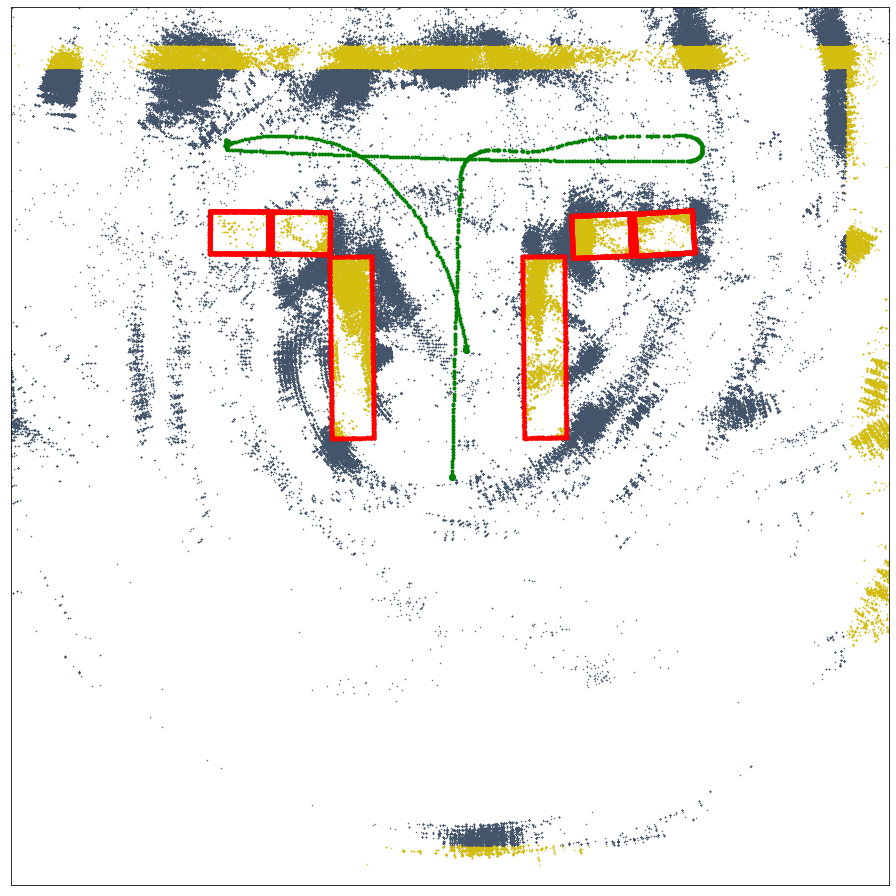

In [41]:
# plot_2dscene(abs_mmw, obstacles=abs_obstacles, colors=labels)
plot_2dscene(abs_mmw[labels], fake_points=abs_mmw[not_labels], obstacles=abs_obstacles, path=poses, path_size=35,)


In [ ]:

def label_mmw(mmw_readings, labels):
    labelled_mmw = []
    counter = 0

    for i in range(len(mmw_readings)):
        current_size = len(mmw_readings[i])
        labelled_mmw.append(np.column_stack((mmw_readings[i], labels[counter:counter+current_size])).tolist())
        counter += current_size
    return labelled_mmw

labelled_mmw = label_mmw(mmw_readings, labels)

plot_2dscene(abs_mmw, obstacles=abs_obstacles, colors=labels)